In [3]:
!pip install torch_geometric
!pip install torch-scatter torch-sparse torch-cluster torch-spline-conv -f https://data.pyg.org/whl/torch-2.0.0+cu118.html

Looking in links: https://data.pyg.org/whl/torch-2.0.0+cu118.html


Loading MovieLens data...

Training model...
Epoch 0, Train Loss: 14.6484, Val Loss: 14.6724
Epoch 10, Train Loss: 2.7090, Val Loss: 2.7445
Epoch 20, Train Loss: 1.8562, Val Loss: 1.8765
Epoch 30, Train Loss: 1.3343, Val Loss: 1.3363
Epoch 40, Train Loss: 1.2252, Val Loss: 1.2238
Epoch 50, Train Loss: 1.1329, Val Loss: 1.1317
Epoch 60, Train Loss: 1.0818, Val Loss: 1.0845
Epoch 70, Train Loss: 1.0372, Val Loss: 1.0429
Epoch 80, Train Loss: 1.0091, Val Loss: 1.0164
Epoch 90, Train Loss: 0.9866, Val Loss: 0.9985
Epoch 100, Train Loss: 0.9796, Val Loss: 0.9949
Epoch 110, Train Loss: 0.9587, Val Loss: 0.9690
Epoch 120, Train Loss: 0.9466, Val Loss: 0.9646
Epoch 130, Train Loss: 0.9462, Val Loss: 0.9612
Epoch 140, Train Loss: 0.9374, Val Loss: 0.9510
Epoch 150, Train Loss: 0.9384, Val Loss: 0.9521
Epoch 160, Train Loss: 0.9403, Val Loss: 0.9525
Epoch 170, Train Loss: 0.9238, Val Loss: 0.9374
Epoch 180, Train Loss: 0.9263, Val Loss: 0.9398
Epoch 190, Train Loss: 0.9178, Val Loss: 0.9294
Epoc

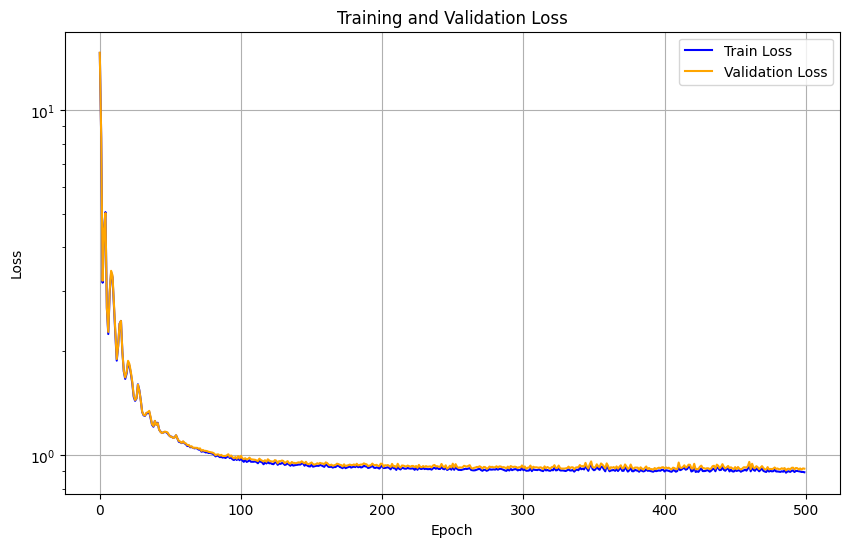

In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.data import Data
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import urllib.request
import zipfile
import os

def download_and_load_movielens():
    url = 'http://files.grouplens.org/datasets/movielens/ml-100k.zip'
    data_dir = 'ml-100k'

    if not os.path.exists(data_dir):
        print("Downloading MovieLens 100k dataset...")
        urllib.request.urlretrieve(url, 'ml-100k.zip')
        with zipfile.ZipFile('ml-100k.zip', 'r') as zip_ref:
            zip_ref.extractall()
        os.remove('ml-100k.zip')

    ratings = pd.read_csv(
        f'{data_dir}/u.data',
        sep='\t',
        names=['user_id', 'movie_id', 'rating', 'timestamp'],
        encoding='latin-1'
    )

    movies = pd.read_csv(
        f'{data_dir}/u.item',
        sep='|',
        encoding='latin-1',
        usecols=[0, 1],
        names=['movie_id', 'title']
    )

    user_encoder = LabelEncoder()
    movie_encoder = LabelEncoder()

    ratings['user_id'] = user_encoder.fit_transform(ratings['user_id'])
    ratings['movie_id'] = movie_encoder.fit_transform(ratings['movie_id'])

    num_users = ratings['user_id'].nunique()
    num_movies = ratings['movie_id'].nunique()

    edge_index = torch.tensor([
        ratings['user_id'].values,
        ratings['movie_id'].values + num_users
    ], dtype=torch.long)

    edge_weight = torch.tensor(ratings['rating'].values, dtype=torch.float)

    x = torch.eye(num_users + num_movies)

    data = Data(
        x=x,
        edge_index=edge_index,
        edge_attr=edge_weight,
        num_users=num_users,
        num_movies=num_movies
    )

    return data, movies, num_users, num_movies

class GNNRecommender(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(GNNRecommender, self).__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, output_dim)
        self.linear = nn.Linear(output_dim * 2, 1)

    def forward(self, data):
        x, edge_index, edge_weight = data.x, data.edge_index, data.edge_attr
        x = self.conv1(x, edge_index, edge_weight)
        x = F.relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index, edge_weight)

        user_emb = x[:data.num_users]
        movie_emb = x[data.num_users:]

        edge_index_user = data.edge_index[0]
        edge_index_movie = data.edge_index[1] - data.num_users

        user_movie_emb = torch.cat([
            user_emb[edge_index_user],
            movie_emb[edge_index_movie]
        ], dim=1)

        pred = self.linear(user_movie_emb)
        return pred.squeeze()

    def get_embeddings(self, data):
        x, edge_index, edge_weight = data.x, data.edge_index, data.edge_attr
        x = self.conv1(x, edge_index, edge_weight)
        x = F.relu(x)
        x = self.conv2(x, edge_index, edge_weight)
        return x

def train_model(model, data, optimizer, epochs=500):
    model.train()
    losses = []

    perm = torch.randperm(data.edge_index.size(1))
    train_size = int(0.8 * data.edge_index.size(1))
    train_idx = perm[:train_size]
    val_idx = perm[train_size:]

    for epoch in range(epochs):
        optimizer.zero_grad()

        pred = model(data)
        train_loss = F.mse_loss(pred[train_idx], data.edge_attr[train_idx])
        train_loss.backward()
        optimizer.step()

        with torch.no_grad():
            val_loss = F.mse_loss(pred[val_idx], data.edge_attr[val_idx])

        losses.append((train_loss.item(), val_loss.item()))

        if epoch % 10 == 0:
            print(f'Epoch {epoch}, Train Loss: {train_loss.item():.4f}, '
                  f'Val Loss: {val_loss.item():.4f}')

    return losses

def get_recommendations(model, data, movies_df, user_id, num_recommendations=5):
    model.eval()
    with torch.no_grad():
        embeddings = model.get_embeddings(data)
        user_emb = embeddings[user_id]
        movie_emb = embeddings[data.num_users:]

        scores = torch.matmul(movie_emb, user_emb)
        _, top_indices = torch.topk(scores, num_recommendations)

        recommended_movie_ids = top_indices.cpu().numpy()
        recommendations = movies_df.iloc[recommended_movie_ids]

        return recommendations[['movie_id', 'title']]

def main():
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    print("Loading MovieLens data...")
    data, movies_df, num_users, num_movies = download_and_load_movielens()
    data = data.to(device)

    input_dim = num_users + num_movies
    hidden_dim = 64
    output_dim = 32

    model = GNNRecommender(input_dim, hidden_dim, output_dim).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

    print("\nTraining model...")
    losses = train_model(model, data, optimizer)

    print("\nRecommendations for user 0:")
    recommendations = get_recommendations(model, data, movies_df, user_id=0)
    print(recommendations.to_string(index=False))

    try:
        import matplotlib.pyplot as plt
        train_losses, val_losses = zip(*losses)
        plt.figure(figsize=(10, 6))
        plt.plot(train_losses, label='Train Loss', color='blue')
        plt.plot(val_losses, label='Validation Loss', color='orange')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title('Training and Validation Loss')
        plt.legend()
        plt.grid(True)
        plt.yscale('log')
        plt.show()
    except ImportError:
        print("Matplotlib not installed, skipping loss visualization")

if __name__ == "__main__":
    main()